# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>

In [9]:
import pandas as pd
import sys
print(sys.executable)
!python --version
import matplotlib.pyplot as plt

g:\Conda\python.exe
Python 3.12.7


In [10]:
## sikit learn model
from sklearn.ensemble import IsolationForest

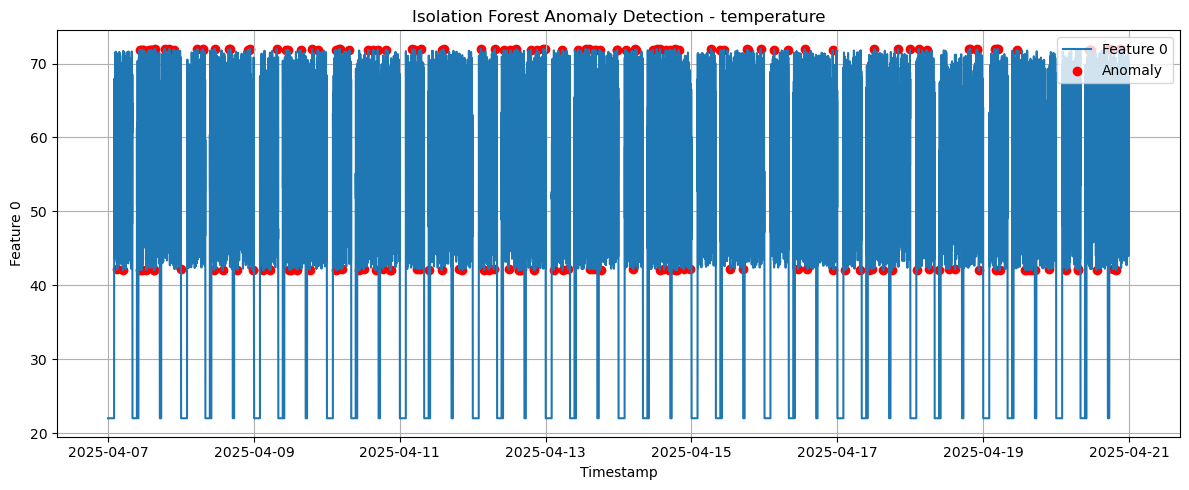

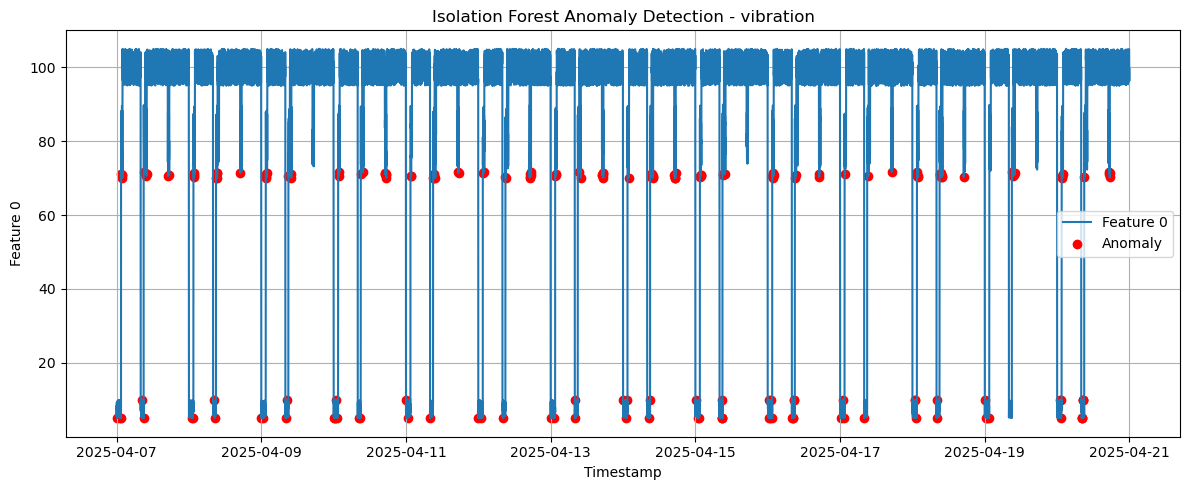

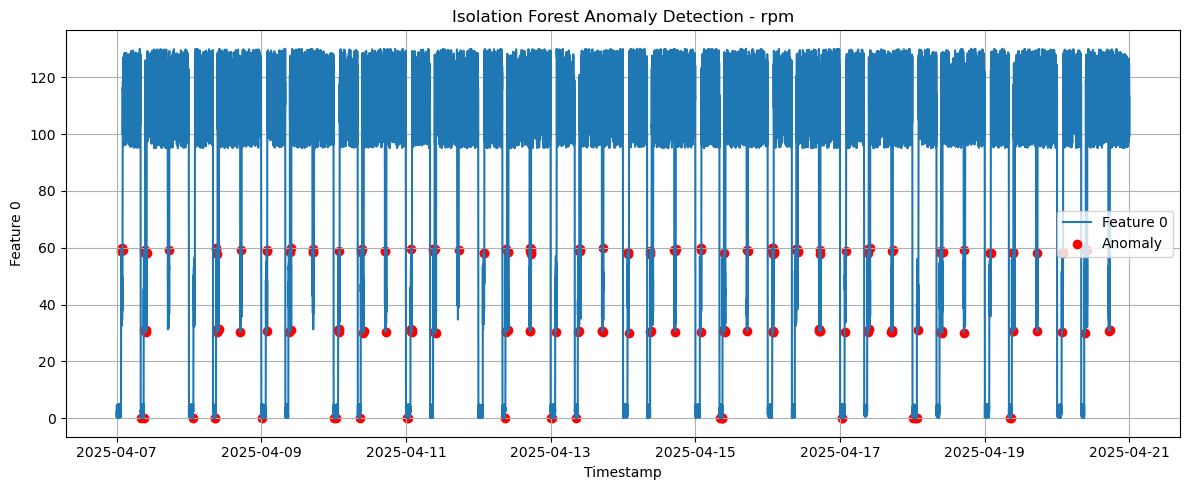

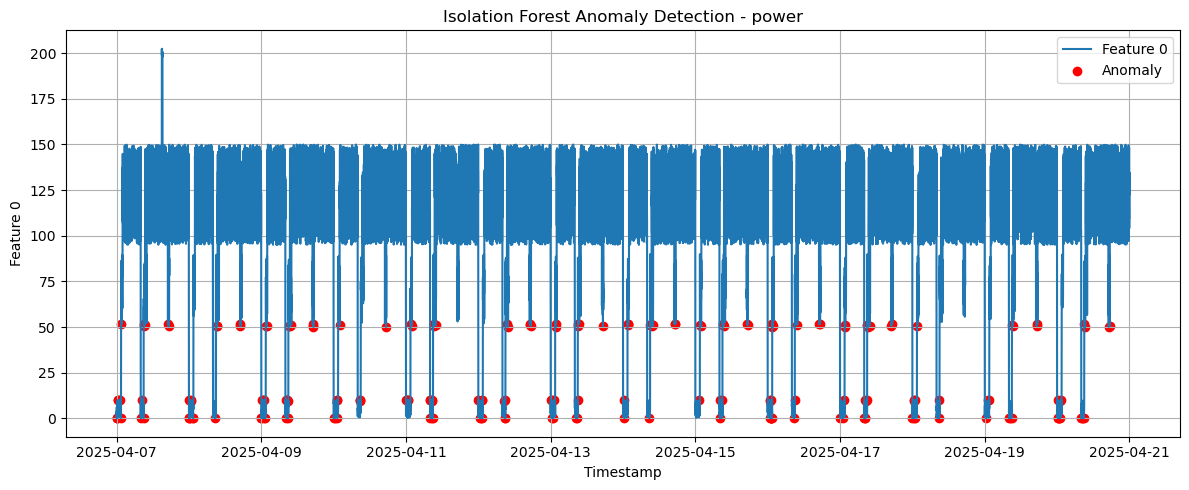

In [11]:
# Load data
file_name = "../test_csv/motor_power_high.csv"
df = pd.read_csv(file_name, parse_dates=["timestamp"])

tags = df["sensor"].unique()

for tag in tags:
    tag_df = df[df["sensor"] == tag].copy()

    # Train only on normal data
    X_train = tag_df[tag_df["is_anomaly"] == False][["feature_0"]]

    # Train Isolation Forest
    model = IsolationForest(contamination=0.01, random_state=42)
    model.fit(X_train)

    # Predict on full tag data
    tag_df["anomaly_label"] = model.predict(tag_df[["feature_0"]])
    tag_df["anomaly_label"] = tag_df["anomaly_label"].map({1: False, -1: True})

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(tag_df["timestamp"], tag_df["feature_0"], label="Feature 0")

    anomalies = tag_df[tag_df["anomaly_label"] == True]
    plt.scatter(anomalies["timestamp"], anomalies["feature_0"], color="red", label="Anomaly")

    plt.title(f"Isolation Forest Anomaly Detection - {tag}")
    plt.xlabel("Timestamp")
    plt.ylabel("Feature 0")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
